In [40]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Import the datasets
afreeca_df = pd.read_csv('./data/afreeca_dataset.csv')
amazon_df = pd.read_csv('./data/amazon_dataset.csv')
battleground_df = pd.read_csv('./data/battleground_dataset.csv')
gamebox_df = pd.read_csv('./data/gamebox_dataset.csv')
geforce_df = pd.read_csv('./data/geforce_dataset.csv')
meet_df = pd.read_csv('./data/meet_dataset.csv')
navernow_df = pd.read_csv('./data/navernow_dataset.csv')
netflix_df = pd.read_csv('./data/netflix_dataset.csv')
roblox_df = pd.read_csv('./data/roblox_dataset.csv')
teams_df = pd.read_csv('./data/teams_dataset.csv')
tft_df = pd.read_csv('./data/tft_dataset.csv')
youtube_df = pd.read_csv('./data/youtube_dataset.csv')
youtubeLive_df = pd.read_csv('./data/youtubeLive_dataset.csv')
zepeto_df = pd.read_csv('./data/zepeto_dataset.csv')
zoom_df = pd.read_csv('./data/zoom_dataset.csv')



In [41]:
# Add datasets to a list
datasets = [afreeca_df, amazon_df, battleground_df, gamebox_df, geforce_df, meet_df, navernow_df, netflix_df, roblox_df, teams_df, tft_df, youtube_df, youtubeLive_df, zepeto_df, zoom_df]

# Create a list of the names of the datasets
dataset_names = ['Afreeca', 'Amazon', 'Battleground', 'Gamebox', 'Geforce', 'Meet', 'Naver Now', 'Netflix', 'Roblox', 'Teams', 'TFT', 'YouTube', 'YouTube Live', 'Zepeto', 'Zoom']

# Group the datasets based on type of traffic

# Video streaming
video_datasets = [amazon_df, netflix_df, youtube_df]
video_dataset_names = ['Amazon', 'Netflix', 'YouTube']

# Video conferencing
video_conference_datasets = [meet_df, teams_df, zoom_df]
video_conference_dataset_names = ['Meet', 'Teams', 'Zoom']

# Live streaming
live_streaming_datasets = [afreeca_df, navernow_df, youtubeLive_df]
live_streaming_dataset_names = ['Afreeca', 'Naver Now', 'YouTube Live']

# Metaverse
metaverse_datasets = [roblox_df, zepeto_df]
metaverse_dataset_names = ['Roblox', 'Zepeto']

# Gaming
gaming_datasets = [battleground_df, tft_df]
gaming_dataset_names = ['Battleground', 'TFT']

# Game streaming 
game_streaming_datasets = [gamebox_df, geforce_df]
game_streaming_dataset_names = ['Gamebox', 'Geforce']


In [42]:
# Create copies of the datasets for DL and UL
datasets_dl = datasets.copy()
datasets_ul = datasets.copy()

# Rename the index column to Time
for i in range(len(datasets)):
    datasets_dl[i] = datasets_dl[i].rename(columns={'Unnamed: 0': 'Time'})
    datasets_ul[i] = datasets_ul[i].rename(columns={'Unnamed: 0': 'Time'})

# For the dl datasets, remove the UL columns
for i in range(len(datasets_dl)):
    datasets_dl[i] = datasets_dl[i].drop(columns=['UL_bitrate'])

# For the ul datasets, remove the DL columns
for i in range(len(datasets_ul)):
    datasets_ul[i] = datasets_ul[i].drop(columns=['DL_bitrate'])

In [43]:
# Create a function to calculate the IQR of each UL and DL dataset and to store whether the data is an outlier or not
def find_outliers(dataset, bitrate_type, quantile, iqr_multiplier):
    q1 = dataset[bitrate_type].quantile(quantile)
    q3 = dataset[bitrate_type].quantile(1-quantile)
    iqr = q3 - q1
    data_list = []
    # Add outlier boolean columns to the dataset, 1 if outlier 0 if inlier
    for value in dataset[bitrate_type]:
    
        if value < (q1 - iqr_multiplier * iqr) or value > (q3 + iqr_multiplier * iqr):
            data_list.append(-1)
        else:
            data_list.append(1)
    dataset["Inlier"] = data_list
    return dataset

# Use the function on all the datasets
for i in range(len(datasets_dl)-1):
    datasets_dl[i] = find_outliers(datasets_dl[i], 'DL_bitrate', 0.25, 1.0)
    datasets_ul[i] = find_outliers(datasets_ul[i], 'UL_bitrate', 0.25, 1.0)

datasets_dl[14] = find_outliers(datasets_dl[14], 'DL_bitrate', 0.25, .3)
datasets_ul[14] = find_outliers(datasets_ul[14], 'UL_bitrate', 0.25, .3)

Inlier
 1    94370
-1        3
Name: count, dtype: int64


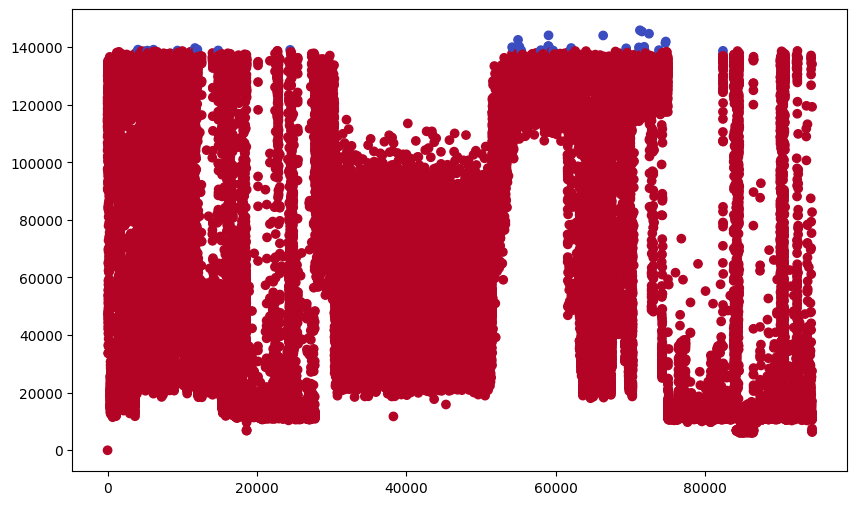

In [44]:
# Plot a graph for dataset 15 (Zoom) to show the outliers
plt.figure(figsize=(10,6))
print(datasets_ul[14].value_counts('Inlier'))
plt.scatter(datasets_dl[14].index, datasets_dl[14]['DL_bitrate'], c=datasets_dl[14]['Inlier'], cmap='coolwarm')

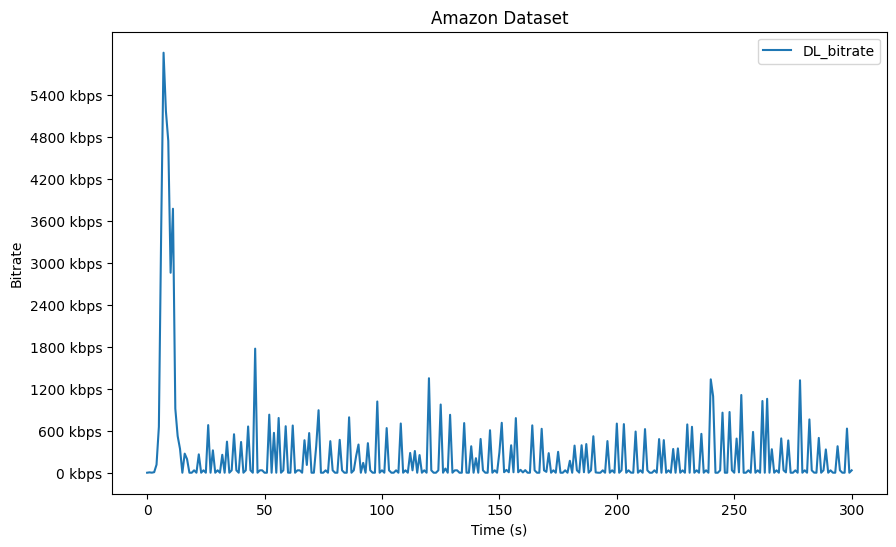

219432
-5


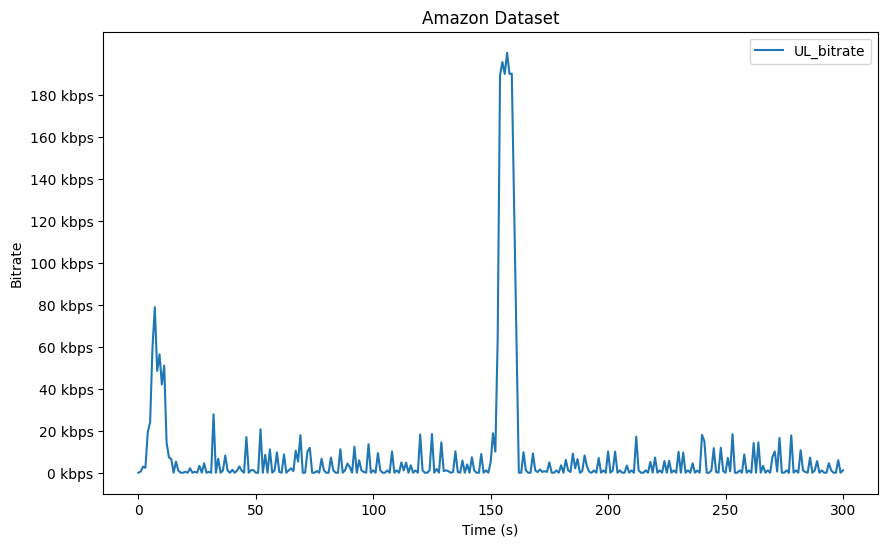

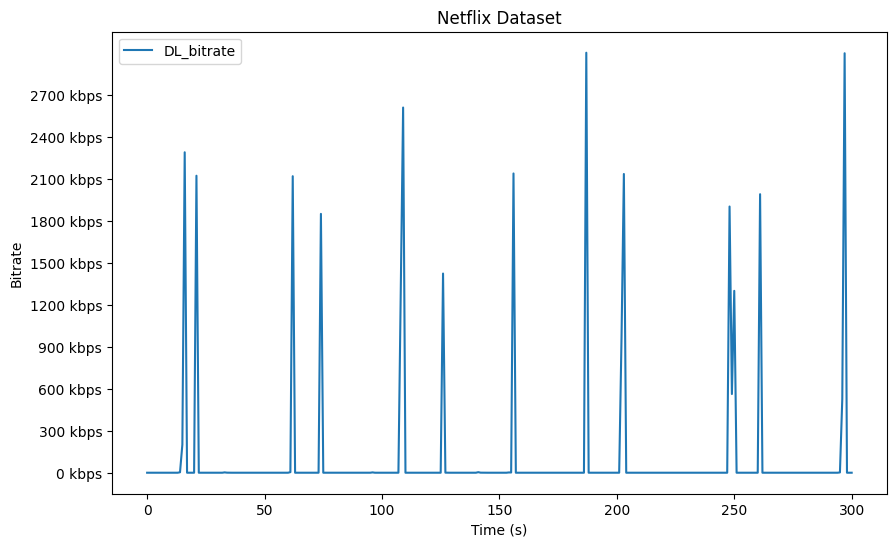

39459
-4


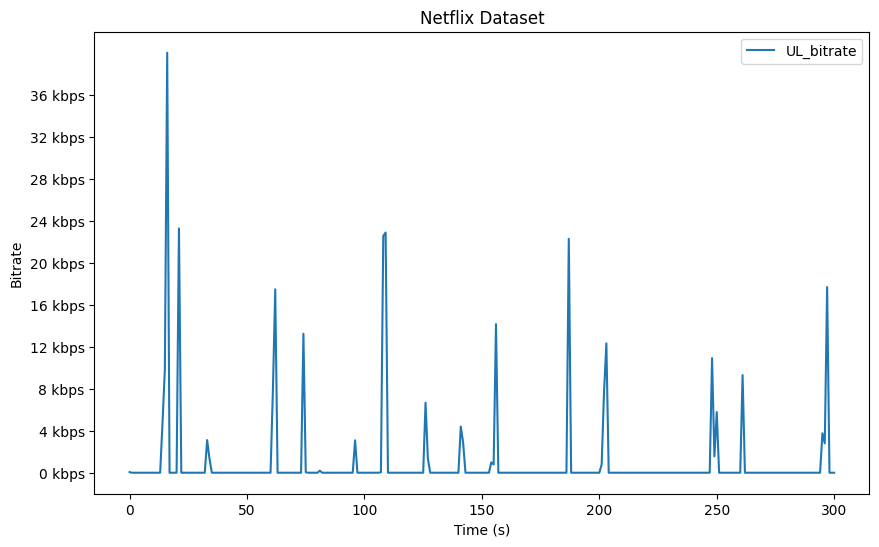

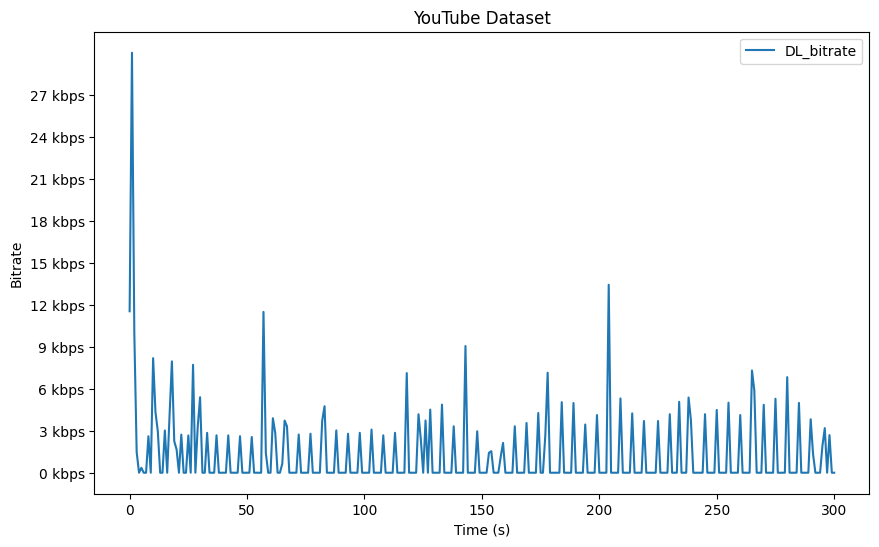

3146546
-6


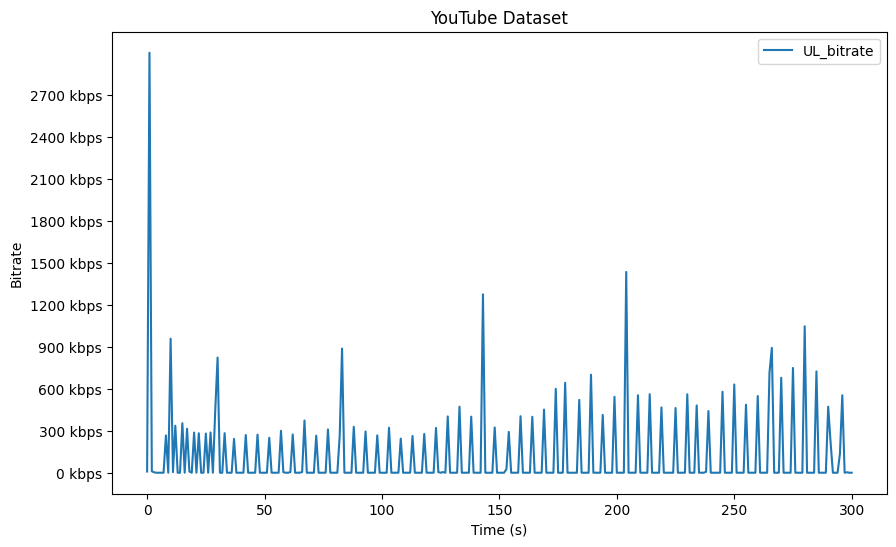

In [45]:
# Perform data visualization
def visualize_data_dl(dataset, dataset_name):
    dataset = dataset.truncate(after=300)
    dataset['DL_bitrate'] = dataset['DL_bitrate'].apply(lambda x: int(x))
    max = dataset['DL_bitrate'].max()
    digits = 1 - len(str(max))
    rounded_max = round(max, digits)
    plt.figure(figsize=(10,6))
    plt.plot(dataset.index, dataset['DL_bitrate'], label='DL_bitrate')
    plt.title(f'{dataset_name} Dataset')
    plt.xlabel('Time (s)')
    # Change the y-axis values to be in kbps
    plt.yticks(np.arange(0, max, max/10), [f'{int(i/1000)} kbps' for i in np.arange(0, rounded_max, rounded_max/10)])
    plt.ylabel('Bitrate')
    #plt.xlim(0, 300)
    plt.legend()
    plt.show()
    #print(dataset['DL_bitrate'].max())

def visualize_data_ul(dataset, dataset_name):
    dataset = dataset.truncate(after=300)
    dataset['UL_bitrate'] = dataset['UL_bitrate'].apply(lambda x: int(x))
    max = dataset['UL_bitrate'].max()
    digits = 1 - len(str(max))
    rounded_max = round(max, digits)
    print(max)
    print(digits)
    plt.figure(figsize=(10,6))
    plt.plot(dataset.index, dataset['UL_bitrate'], label='UL_bitrate')
    plt.title(f'{dataset_name} Dataset')
    plt.xlabel('Time (s)')
    plt.yticks(np.arange(0, max, max/10), [f'{int(i/1000)} kbps' for i in np.arange(0, rounded_max, rounded_max/10)])
    plt.ylabel('Bitrate')
    #plt.xlim(0, 300)
    plt.legend()
    plt.show()
    

def visualize_data(dataset, dataset_name):
    # Visualize the DL and UL data using subplots
    fig, ax = plt.subplots()
    ax.plot(dataset.index, dataset['DL_bitrate'], label='DL_bitrate')
    ax.set_xlabel('Time')
    ax2 = ax.twinx()
    ax2.plot(dataset.index, dataset['UL_bitrate'], color='orange', label='UL_bitrate')
    
    ax.set_ylabel('DL Bitrate', color='blue')
    ax2.set_ylabel('UL Bitrate', color='orange')
    ax.set_title(f'{dataset_name} Dataset')
    ax.legend()
    ax2.legend()

    # Set the y-axis values to be in kbps
    plt.yticks(np.arange(0, dataset['DL_bitrate'].max(), (dataset['DL_bitrate'].max()/10)), [f'{i/1000} kbps' for i in np.arange(0, 1000000, 100000)])
    plt.show()

# Visualize the data for video datasets
for i in range(len(video_datasets)):
    visualize_data_dl(video_datasets[i], video_dataset_names[i])
    visualize_data_ul(video_datasets[i], video_dataset_names[i])
    #visualize_data(video_datasets[i], video_dataset_names[i])

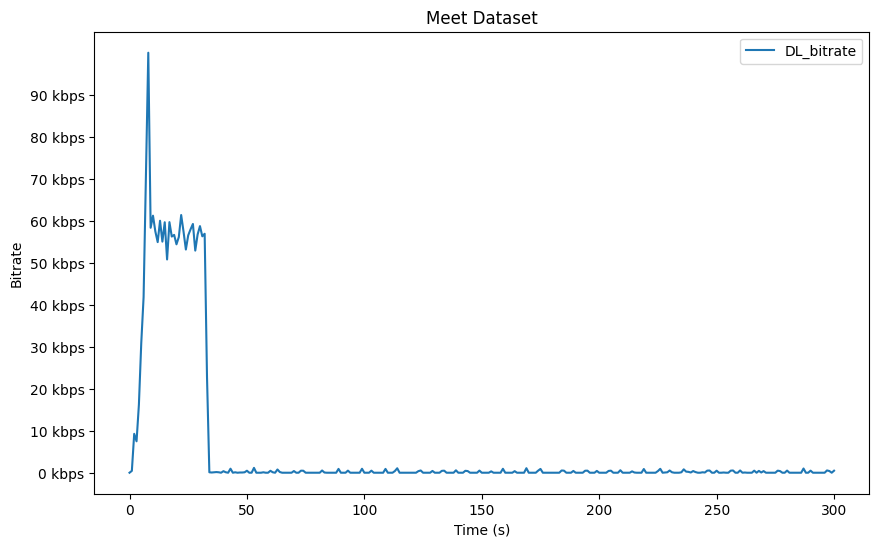

132770
-5


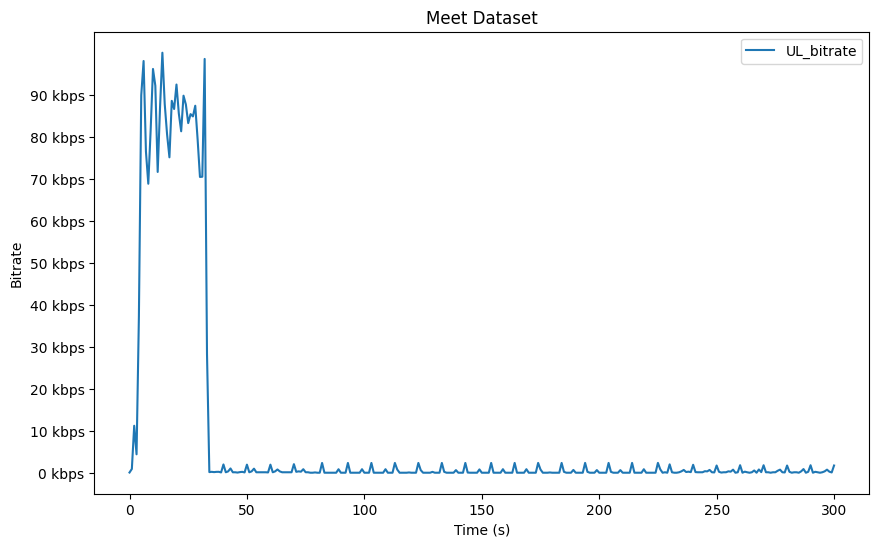

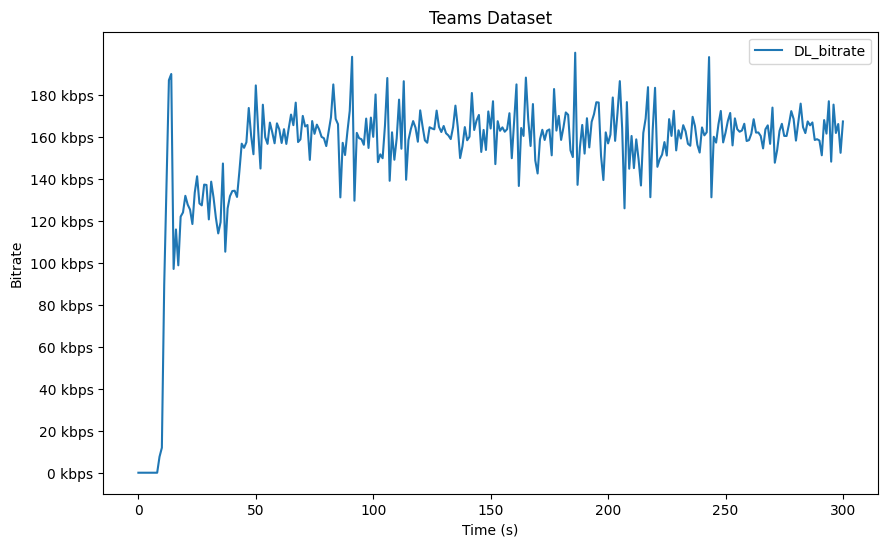

165264
-5


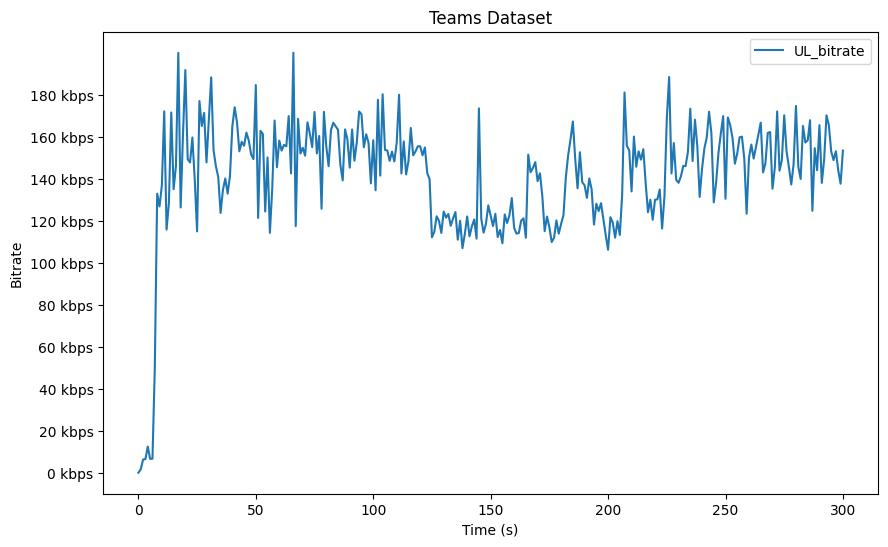

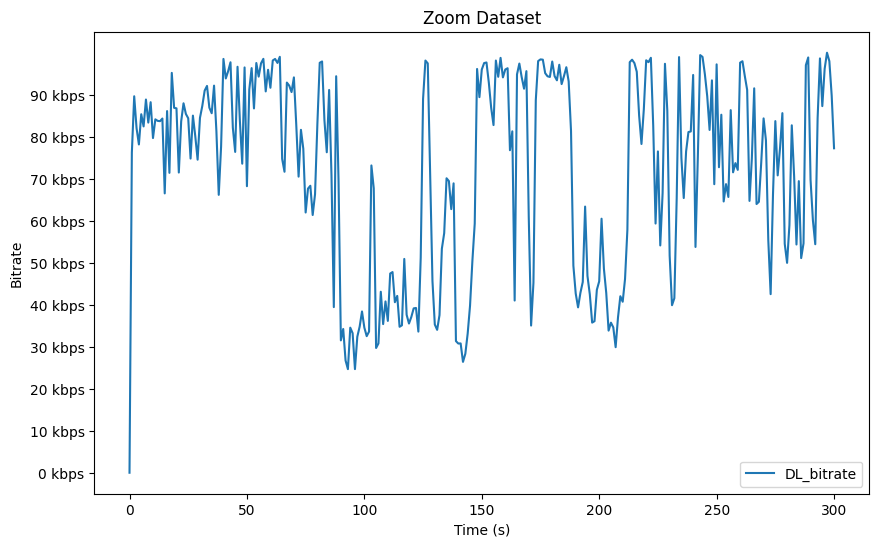

141139
-5


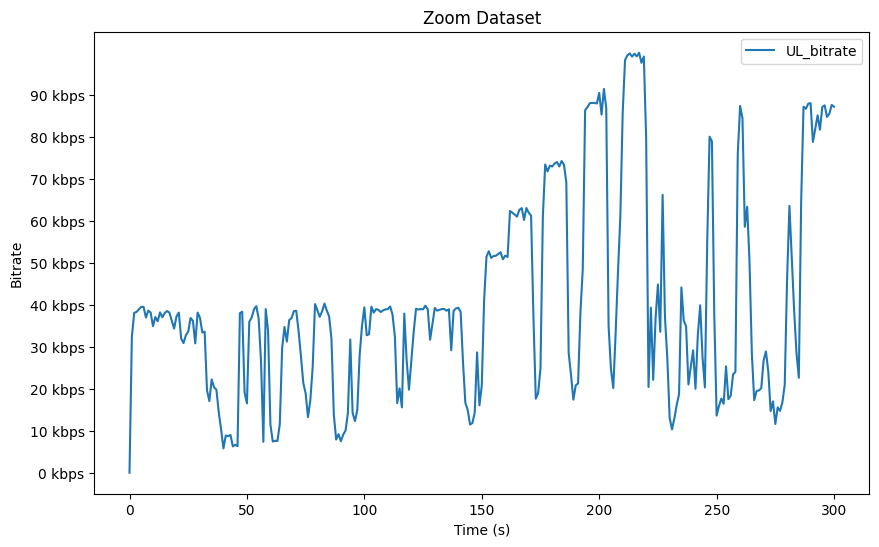

In [46]:
# Visualize the data for video conference datasets
for i in range(len(video_conference_datasets)):
    visualize_data_dl(video_conference_datasets[i], video_conference_dataset_names[i])
    visualize_data_ul(video_conference_datasets[i], video_conference_dataset_names[i])

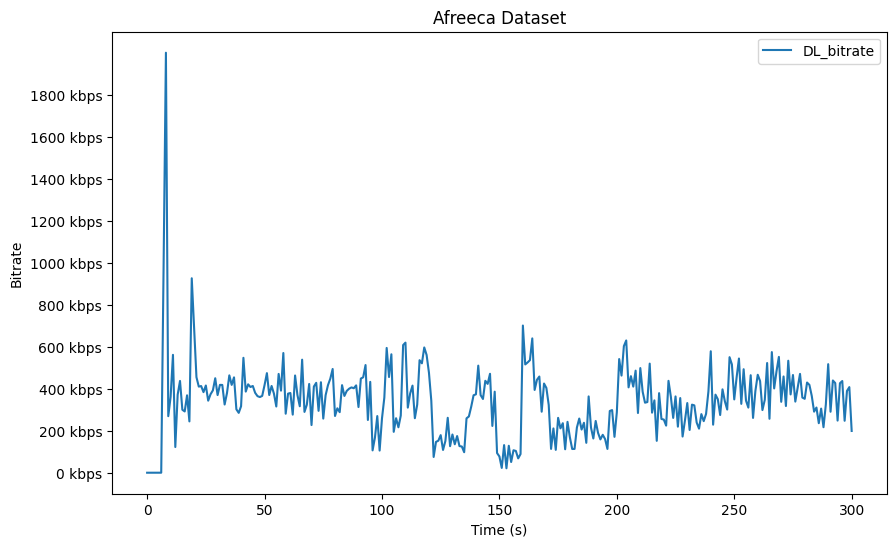

31741
-4


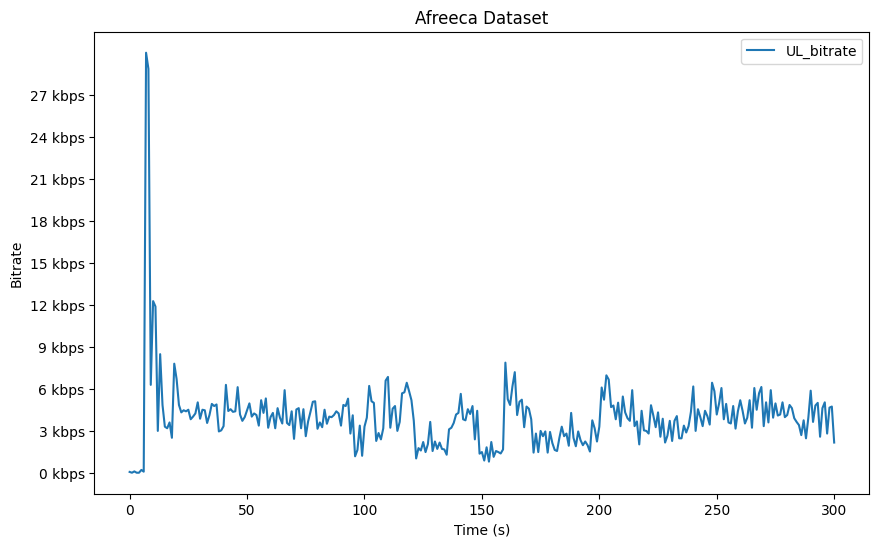

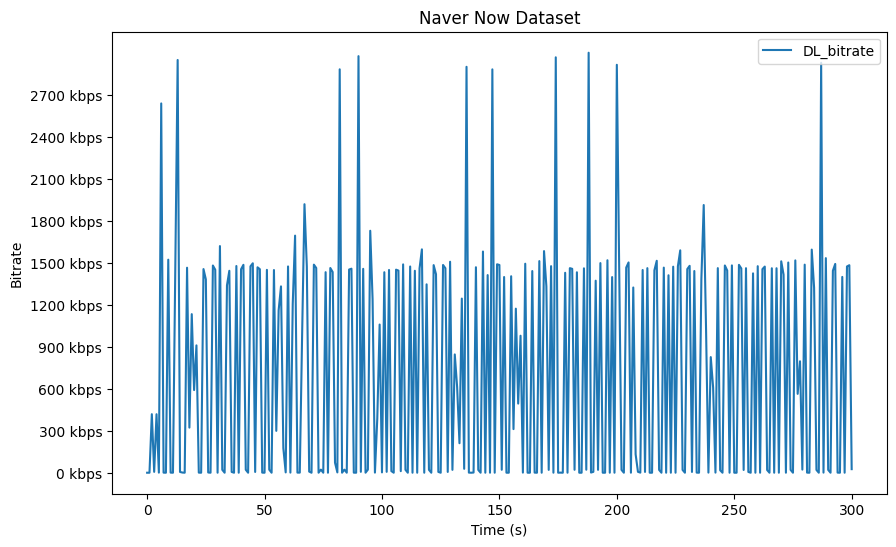

27364
-4


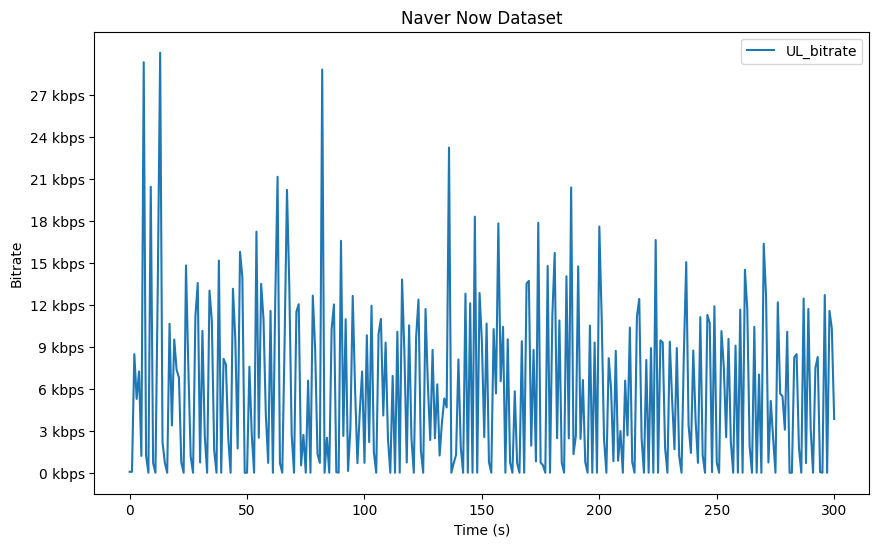

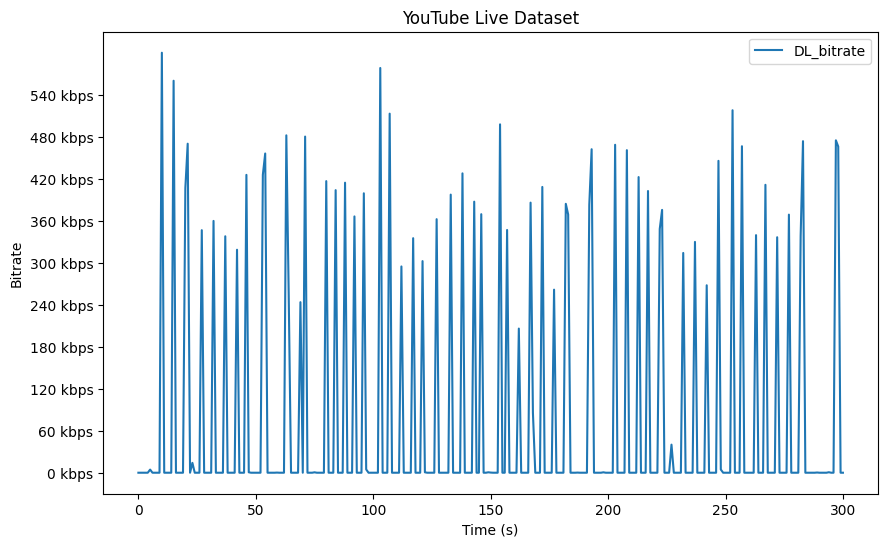

16761
-4


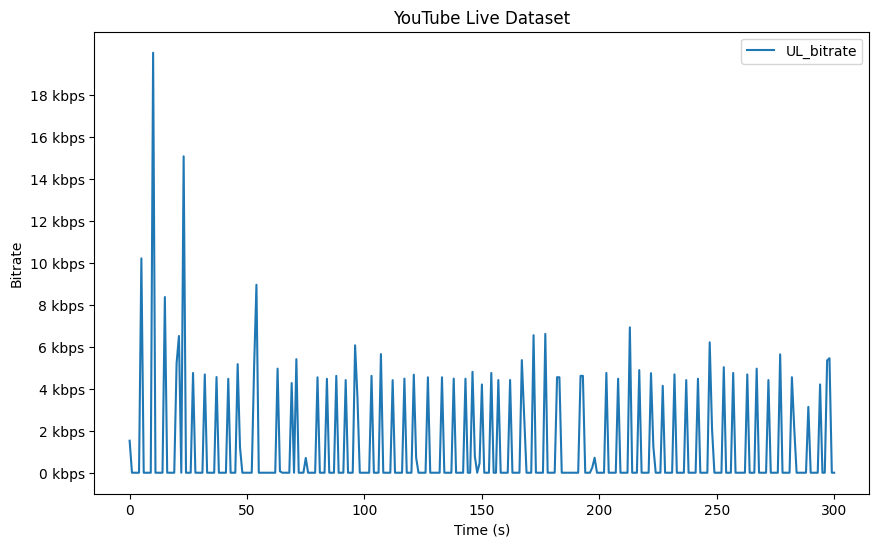

In [47]:
# Visualize the data for live streaming datasets
for i in range(len(live_streaming_datasets)):
    visualize_data_dl(live_streaming_datasets[i], live_streaming_dataset_names[i])
    visualize_data_ul(live_streaming_datasets[i], live_streaming_dataset_names[i])

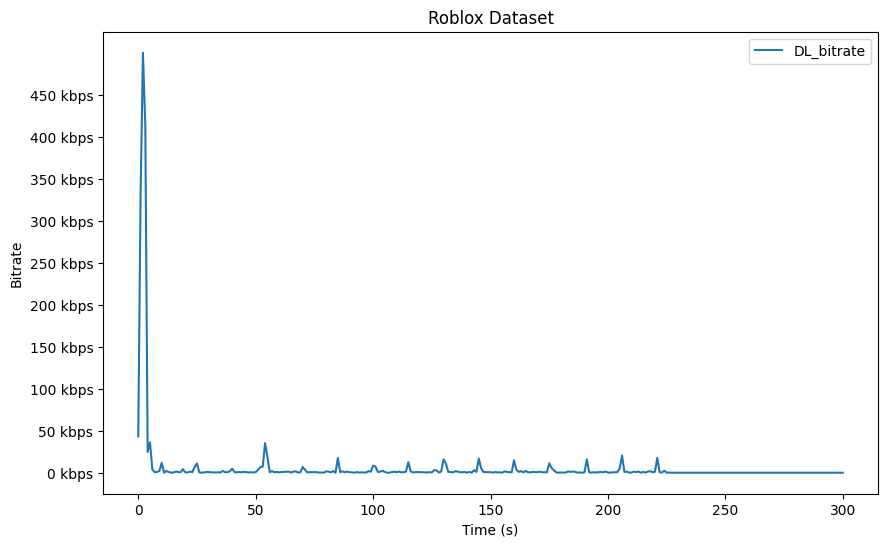

3569
-3


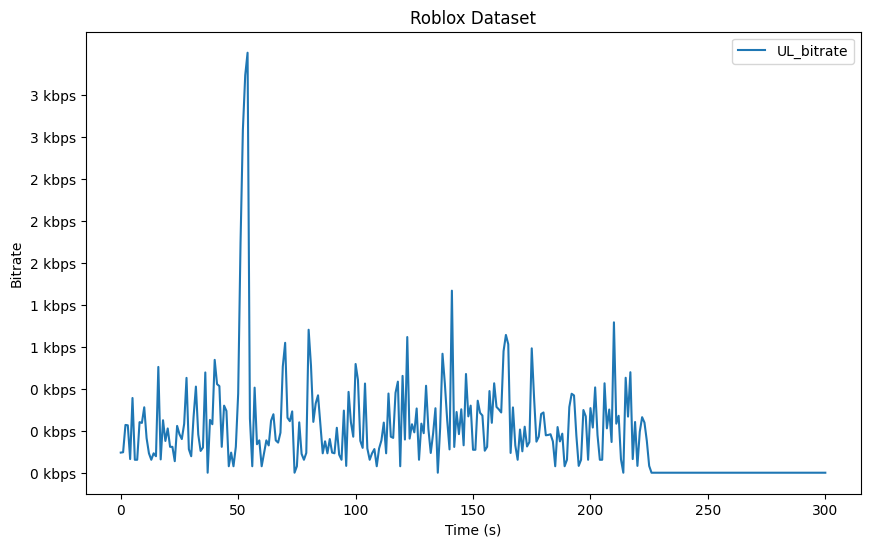

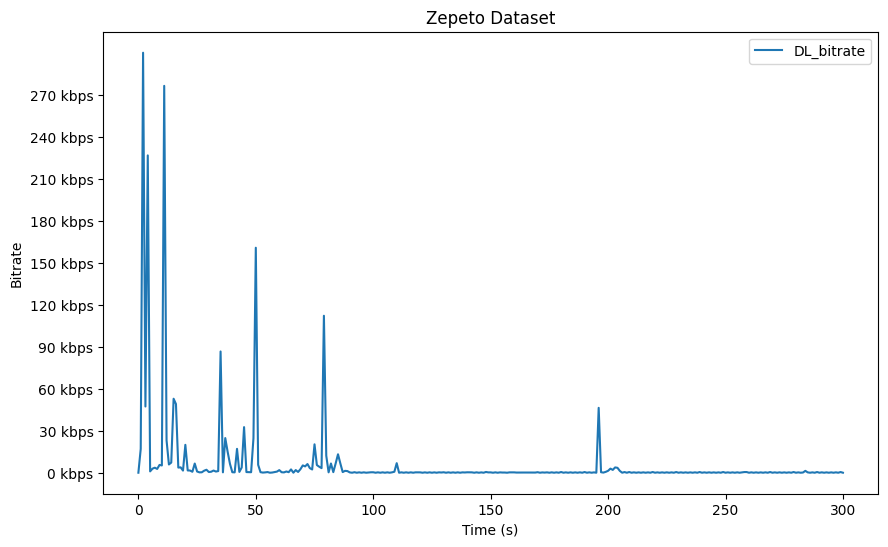

41548
-4


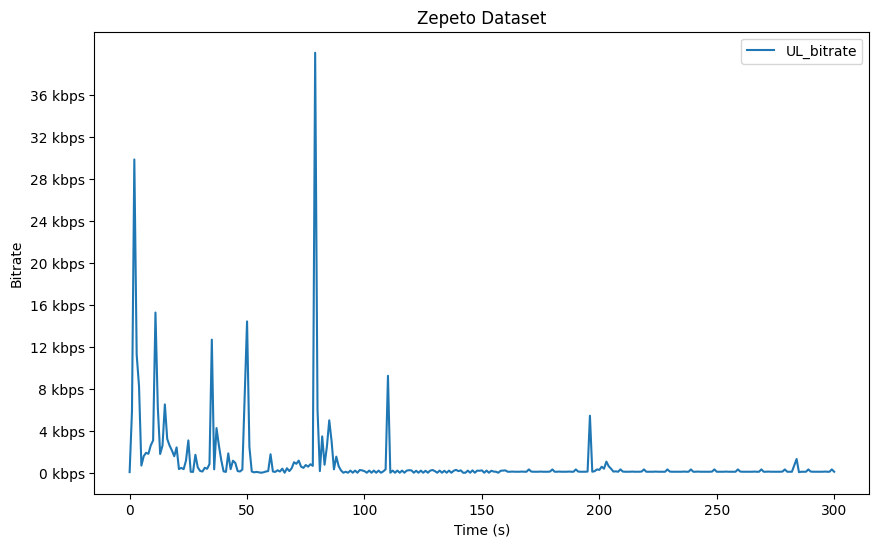

In [48]:
# Visualize the data for metaverse datasets
for i in range(len(metaverse_datasets)):
    visualize_data_dl(metaverse_datasets[i], metaverse_dataset_names[i])
    visualize_data_ul(metaverse_datasets[i], metaverse_dataset_names[i])

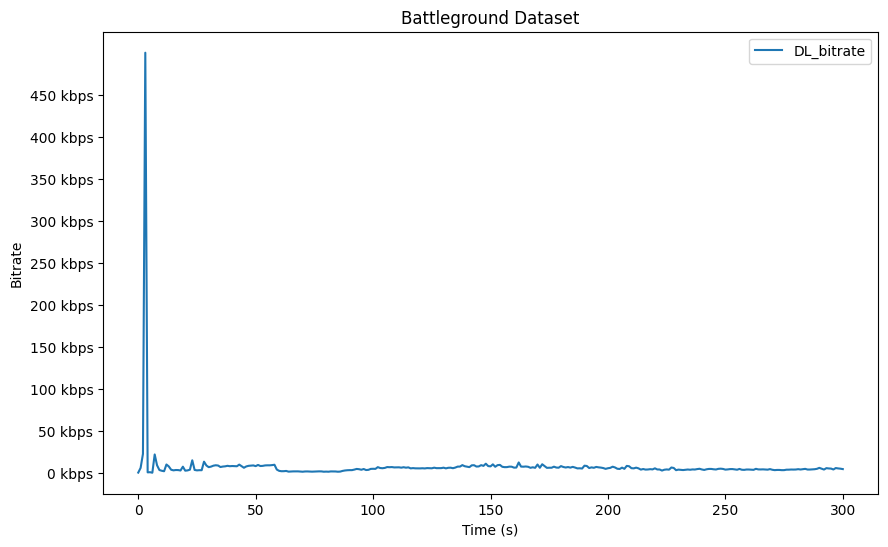

19030
-4


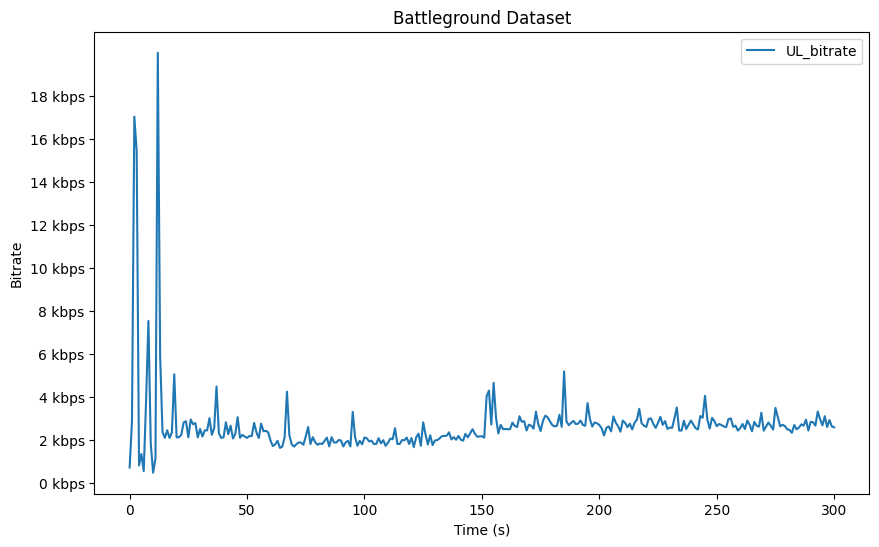

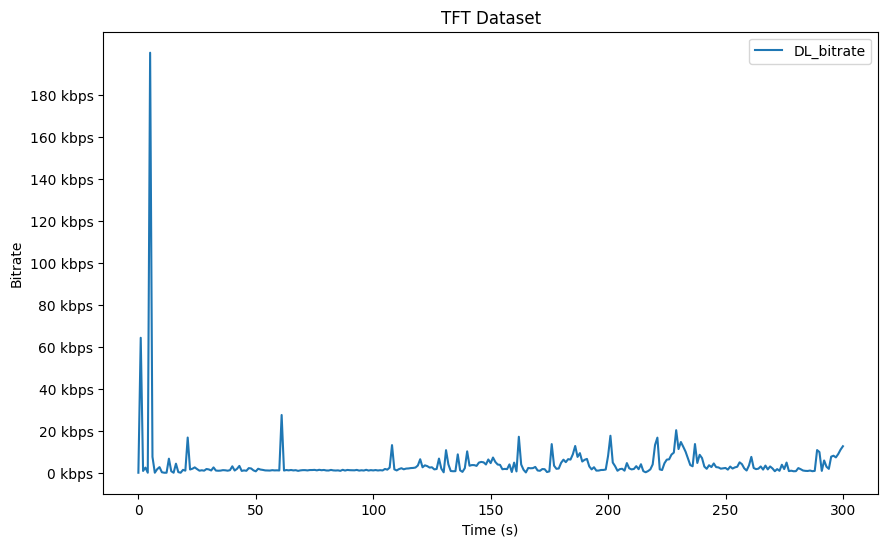

11246
-4


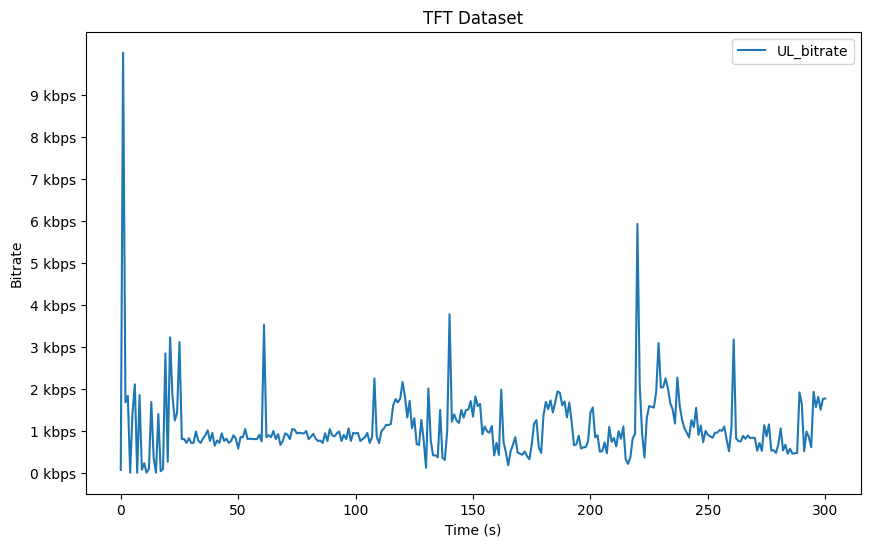

In [49]:
# Visualize the data for gaming datasets
for i in range(len(gaming_datasets)):
    visualize_data_dl(gaming_datasets[i], gaming_dataset_names[i])
    visualize_data_ul(gaming_datasets[i], gaming_dataset_names[i])

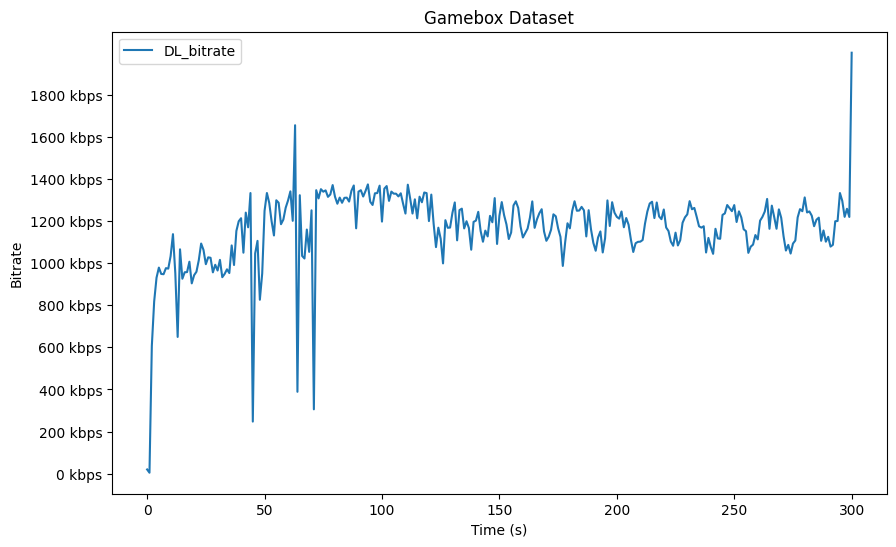

12008
-4


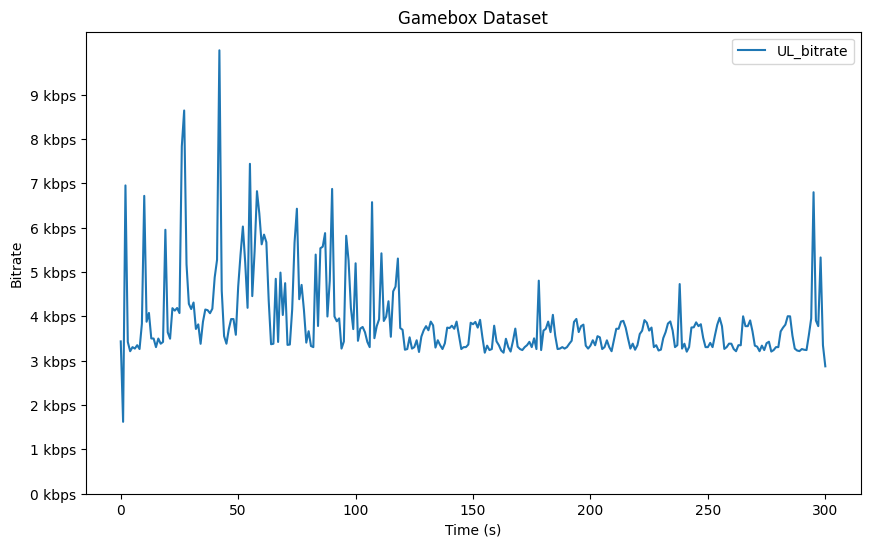

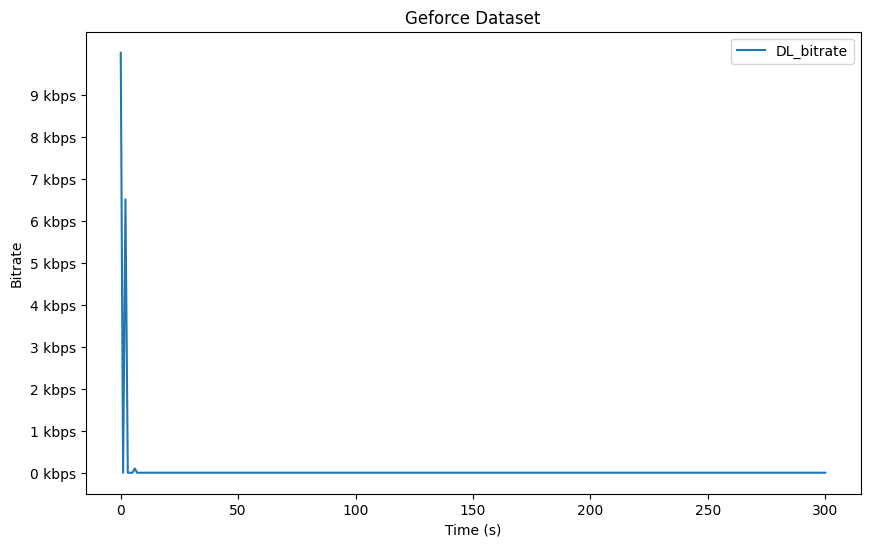

1429
-3


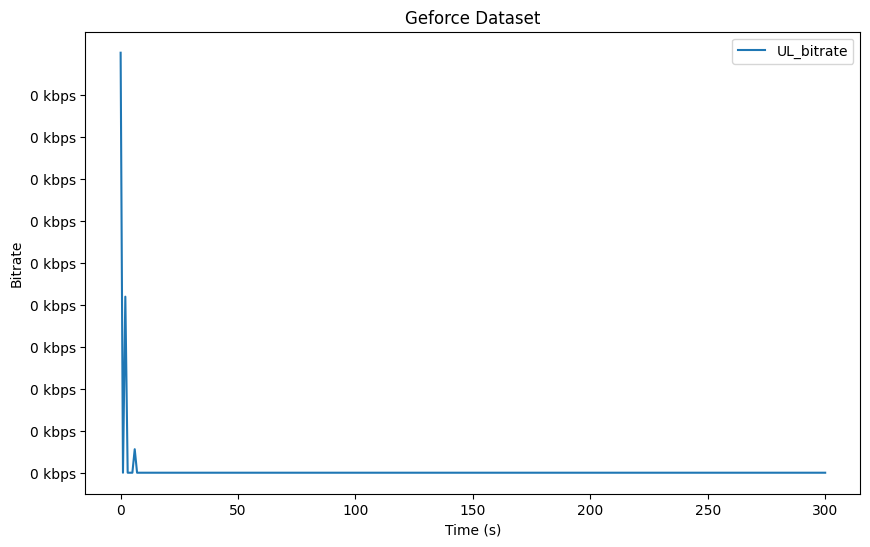

In [50]:
# Visualize the data for game streaming datasets
for i in range(len(game_streaming_datasets)):
    visualize_data_dl(game_streaming_datasets[i], game_streaming_dataset_names[i])
    visualize_data_ul(game_streaming_datasets[i], game_streaming_dataset_names[i])

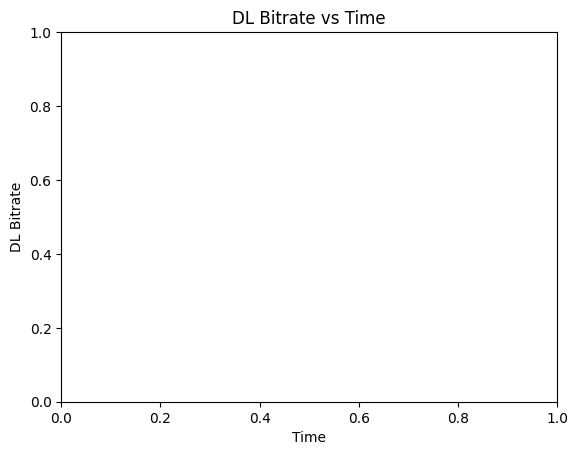

In [51]:
# Visualize the distribution of the data
plt.xlabel('Time')
plt.ylabel('DL Bitrate')
plt.title('DL Bitrate vs Time')
plt.show()


In [52]:
from sklearn.ensemble import IsolationForest

# Split the dataset into training and testing sets
def split_dataset(dataset):
    X = dataset.iloc[:, 0].values
    y = dataset.iloc[:, 1].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1904703, stratify = y)
    # Remove NaN values
    X_train = X_train[~np.isnan(X_train)]
    y_train = y_train[~np.isnan(y_train)]
    return X_train, X_test, y_train, y_test

# Train the Isolation Forest model
def train_model(X_train, y_train, contamination=0.1):
    #sc = StandardScaler()
    #X_train = sc.fit_transform(X_train)
    # Calculate the contamination value
    inliers = y_train[y_train == 1] 
    outliers = y_train[y_train == -1]
    contamination = len(outliers) / len(inliers)
    #Print the contamination value
    #print(contamination)
    classifier = IsolationForest(contamination = contamination, random_state = 1904703)
    classifier.fit(X_train.reshape(-1, 1))
    return classifier

# Train the SVM model
def train_svm_model(X_train, y_train):
    #sc = StandardScaler()
    #X_train = sc.fit_transform(X_train.reshape(-1, 1))
    classifier = SVC(kernel = 'rbf', random_state = 1904703)
    classifier.fit(X_train.reshape(-1, 1), y_train)
    return classifier

# Predict the outliers
def predict_outliers(classifier, X_test):
    y_pred = classifier.predict(X_test.reshape(-1, 1))
    return y_pred

# Evaluate the model
def evaluate_model(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=[1, -1])
    accuracy = accuracy_score(y_test, y_pred)
    return cm, accuracy


Afreeca
0.9937397034596376
Amazon
0.8974751599292228
Battleground
0.9659374134588756
Gamebox
0.9640423242467718
Geforce
0.8343158270811004
Meet
0.9981965317919075
Naver Now
0.8870941265307463
Netflix
1.0
Roblox
0.947746310331073
Teams
0.9961904013824523
TFT
0.9829087391164141
YouTube
1.0
YouTube Live
0.9632139928942334
Zepeto
0.9564936463493431
Zoom
0.9998728490294143


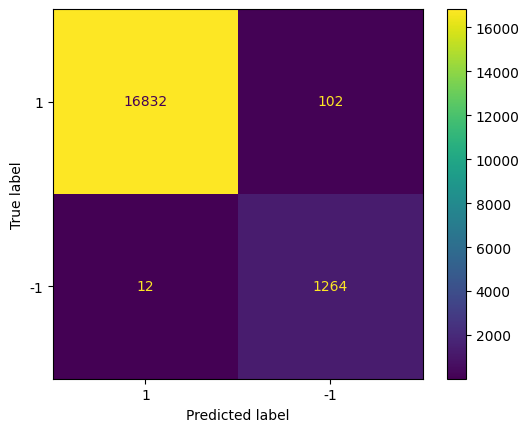

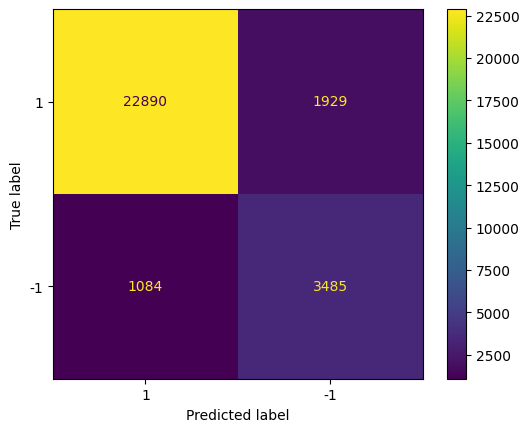

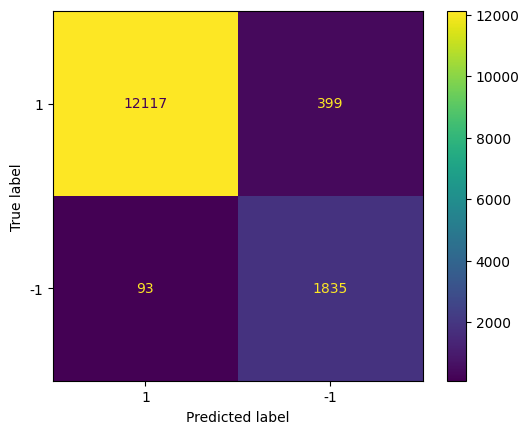

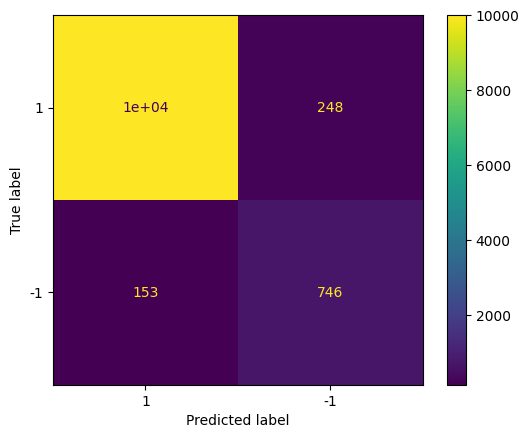

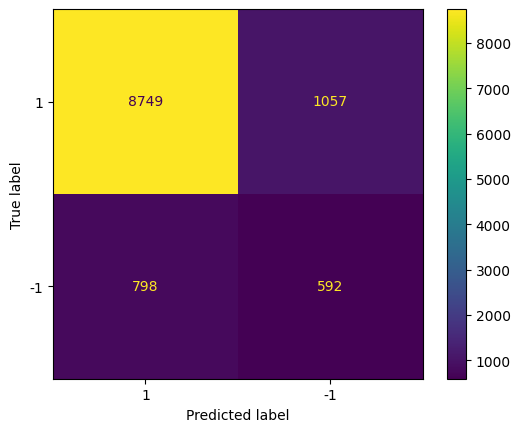

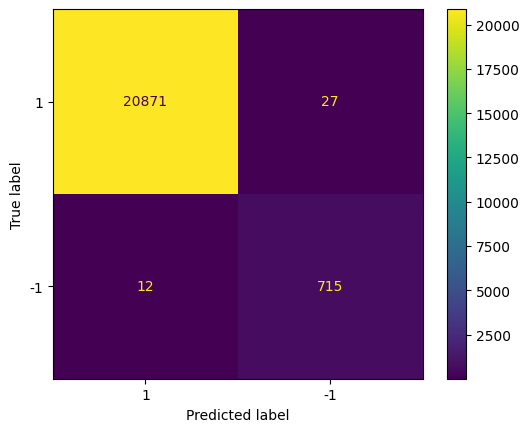

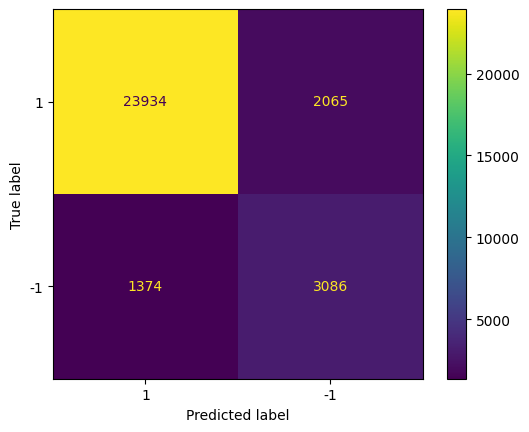

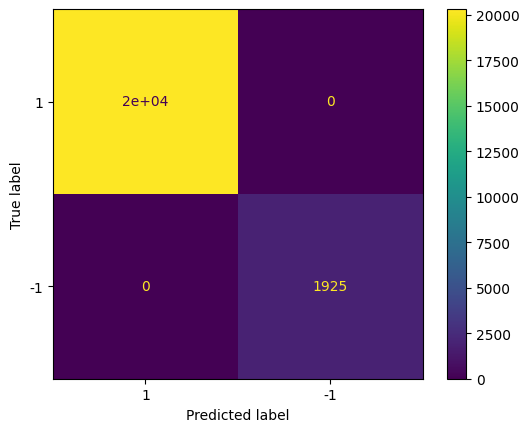

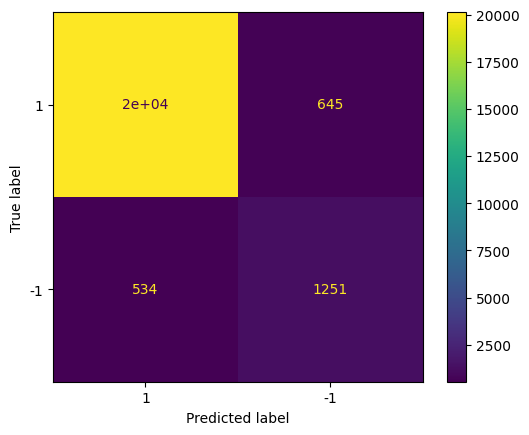

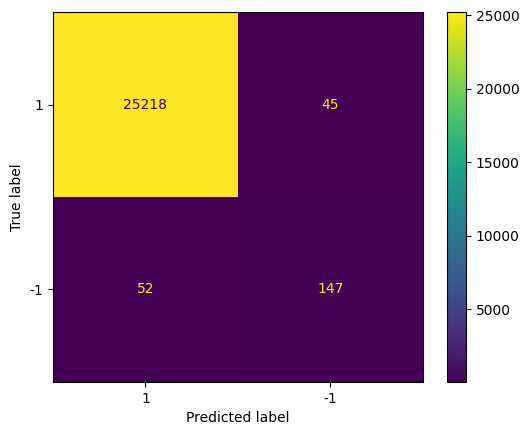

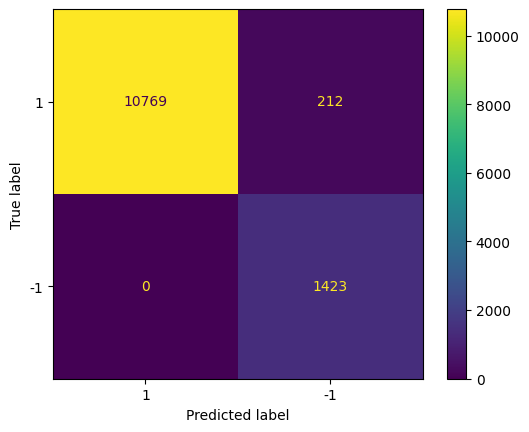

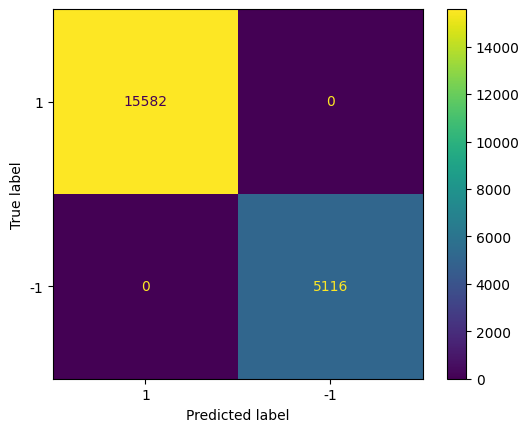

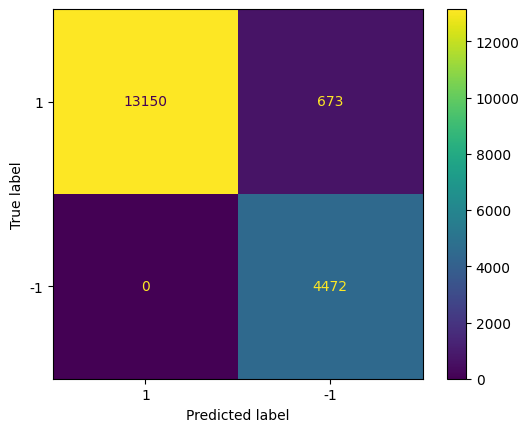

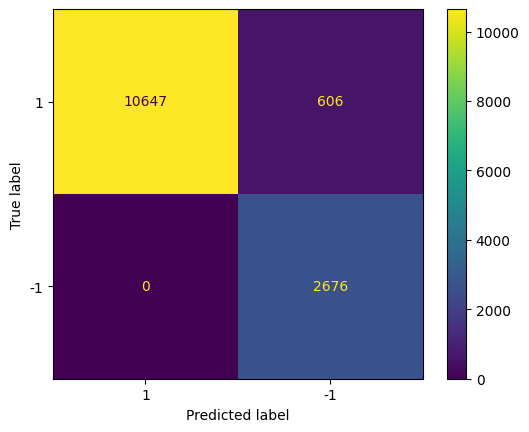

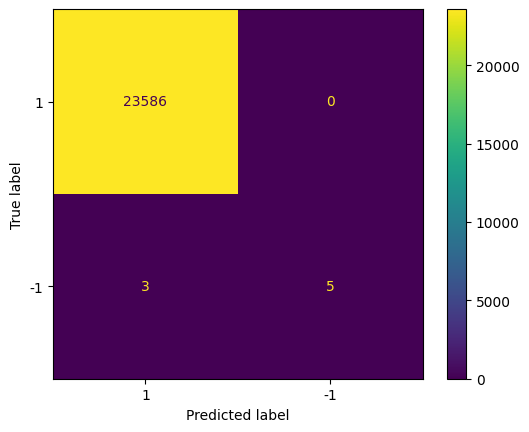

In [53]:
# Import confusion matrix and accuracy score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
dl_classifiers = []
ul_classifiers = []
# Predict the outliers for the dl datasets
count = 0
for dataset in datasets_dl:
    X_train, X_test, y_train, y_test = split_dataset(dataset)
    classifier = train_model(X_train, y_train)
    y_pred = predict_outliers(classifier, X_test)
    cm, accuracy = evaluate_model(y_test, y_pred)
    
    #print(cm)
    display_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])
    print(dataset_names[count])
    # Display the confusion matrix
    print(accuracy)
    display_cm.plot()
    count += 1
    
    dl_classifiers.append(classifier)


Afreeca
0.986051619989017
Amazon
0.984551517626242
Battleground
0.9732068679036278
Gamebox
0.9900466284074605
Geforce
0.9997320471596999
Meet
0.9193988439306359
Naver Now
0.8806592468564299
Netflix
1.0
Roblox
0.9764658954926206
Teams
0.9998429031497919
TFT
0.9764592067075137
YouTube
1.0
YouTube Live
0.9598797485651818
Zepeto
0.9650369732213367
Zoom
0.9999576163431381


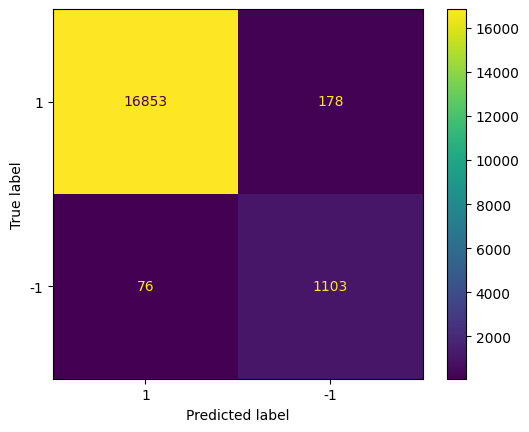

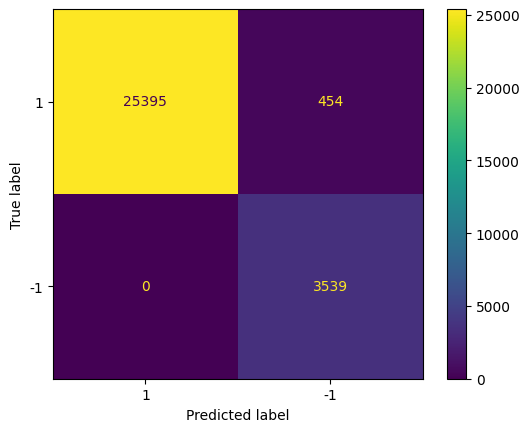

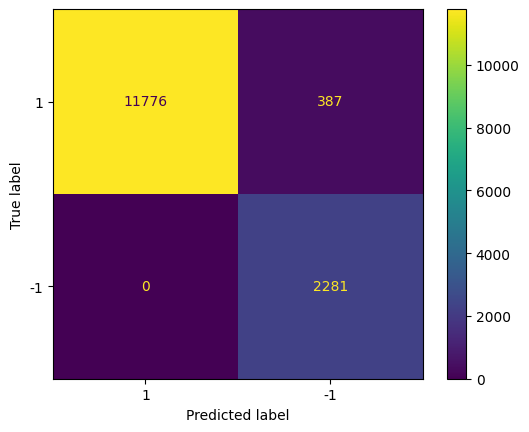

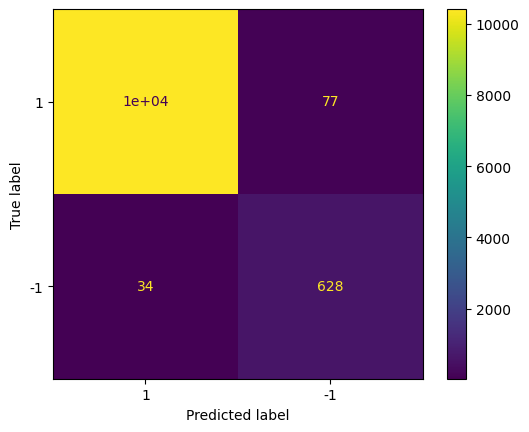

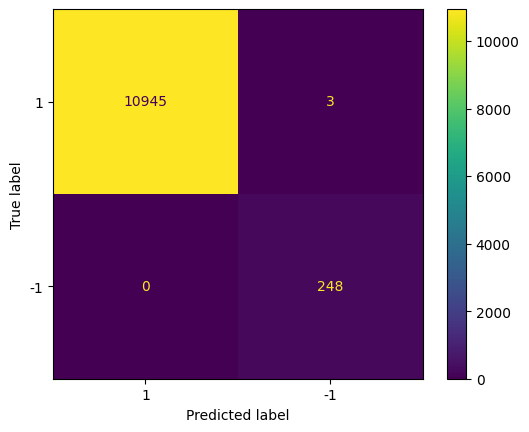

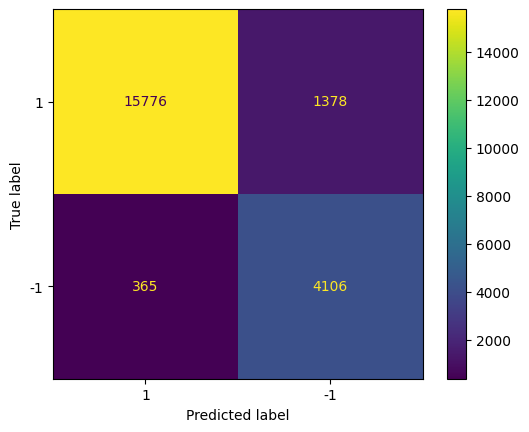

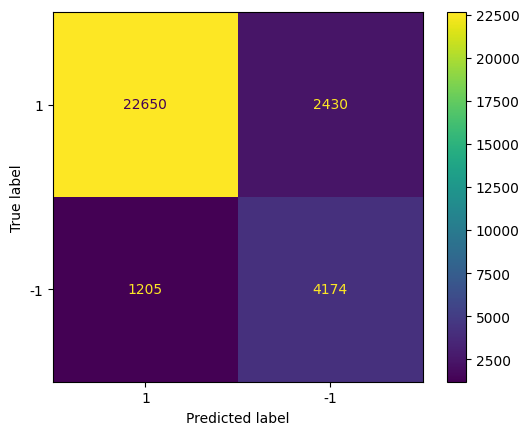

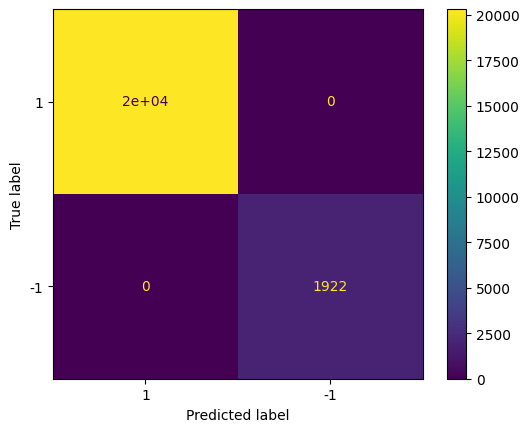

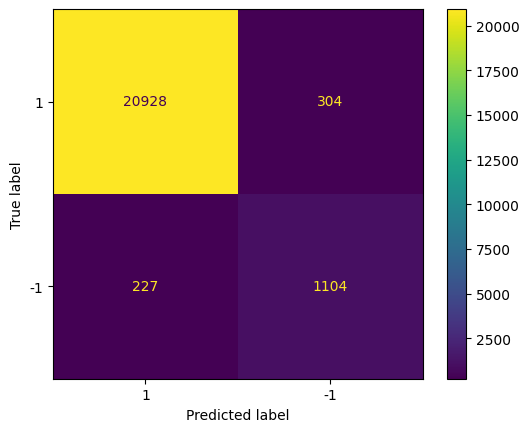

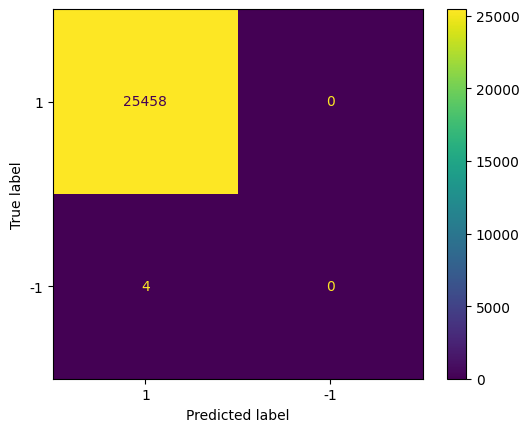

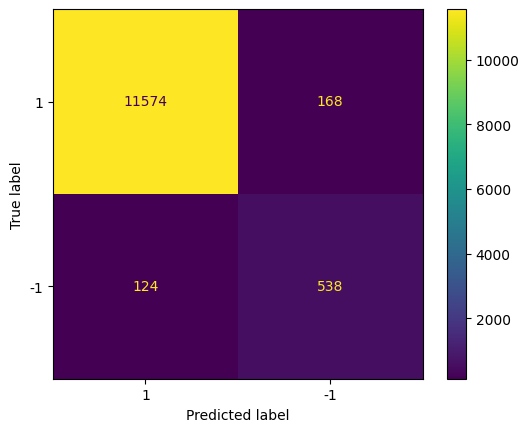

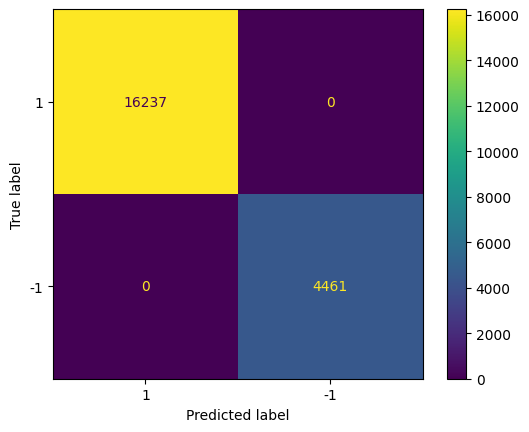

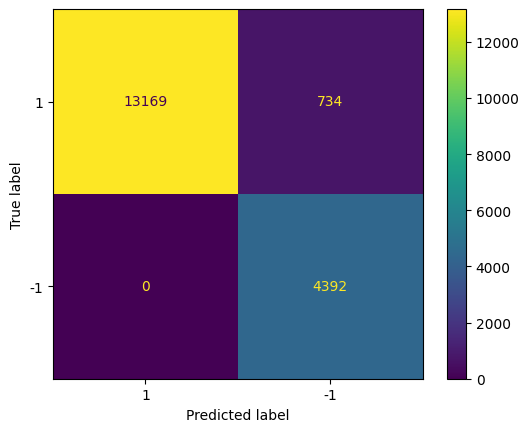

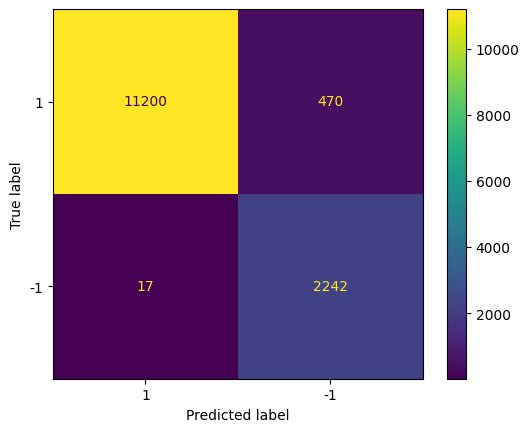

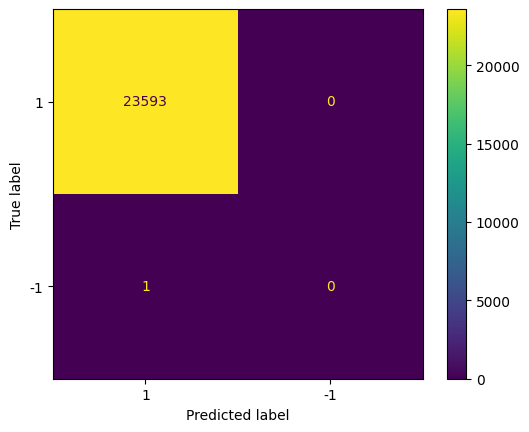

In [54]:
count = 0
# Predict the outliers for the ul datasets
for dataset in datasets_ul:
    X_train, X_test, y_train, y_test = split_dataset(dataset)
    classifier = train_model(X_train, y_train)
    y_pred = predict_outliers(classifier, X_test)
    cm, accuracy = evaluate_model(y_test, y_pred)
    
    display_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])
    display_cm.plot()
    print(dataset_names[count])
    count += 1
    print(accuracy)
    ul_classifiers.append(classifier)

In [55]:
# Export the models
import pickle
with open('afreeca_model.pkl', 'wb') as f:
    pickle.dump(dl_classifiers[0], f)


In [56]:
print(datasets_dl[0].head(10))
print(dl_classifiers[5].predict([[0]]))

   DL_bitrate  Inlier
0         0.0      -1
1         0.0      -1
2        48.0      -1
3         0.0      -1
4         0.0      -1
5       273.0      -1
6        80.0      -1
7    829967.0      -1
8   1706516.0      -1
9    229741.0       1
[1]


In [57]:
# Predict the outliers for the dl datasets using SVM
count = 0
for dataset in datasets_dl:
    X_train, X_test, y_train, y_test = split_dataset(dataset)
    classifier = train_svm_model(X_train, y_train)
    y_pred = predict_outliers(classifier, X_test)
    cm, accuracy = evaluate_model(y_test, y_pred)
    
    display_cm = ConfusionMatrixDisplay(cm, display_labels=[1, 0])
    print(dataset_names[count])
    count += 1
    print(accuracy)
    dl_classifiers.append(classifier)

# Predict the outliers for the ul datasets using SVM


Afreeca
0.9993410214168039
Amazon
0.9994895875867701
Battleground
0.8742730545555247
Gamebox
0.999551649928264
Geforce
0.9981243301178992
Meet
1.0
Naver Now
0.9992777175875768
Netflix
0.9648476130540322
Roblox
0.9998670389575854
Teams
0.999960725787448
TFT
0.999677523379555
YouTube
0.9964730891873611
YouTube Live
0.9857338070511069
Zepeto
0.9966257448488764
Zoom
0.9996609307451046


In [58]:
count = 0
# Every dataset except datasets_ul[2]

for i in range(len(datasets_ul)):
    if i != 2:
        X_train, X_test, y_train, y_test = split_dataset(datasets_ul[i])
        classifier = train_svm_model(X_train, y_train)
        y_pred = predict_outliers(classifier, X_test)
        cm, accuracy = evaluate_model(y_test, y_pred)
        display_cm = ConfusionMatrixDisplay(cm, display_labels=[1, 0])
        print(dataset_names[i])
        count += 1
        print(accuracy)
        ul_classifiers.append(classifier)

Afreeca
0.9986271279516749
Amazon
0.9995916700694161
Gamebox
0.9994619799139168
Geforce
0.9998213647731332
Meet
0.9975491329479769
Naver Now
1.0
Netflix
0.9977973568281938
Roblox
0.9996897575676993
Teams
0.999960725787448
TFT
0.9995162850693324
YouTube
0.9045801526717557
YouTube Live
0.9997813610276032
Zepeto
0.9969847081628258
Zoom
0.9999576163431381


In [59]:
X_train, X_test, y_train, y_test = split_dataset(datasets_ul[2])
# remove one value from y_train
y_train = y_train[:-1]
classifier = train_svm_model(X_train, y_train)
y_pred = predict_outliers(classifier, X_test)
cm, accuracy = evaluate_model(y_test, y_pred)
#display_cm = ConfusionMatrixDisplay(cm, display_labels=[1, 0])
print(dataset_names[2])
print(accuracy)



Battleground
0.8420797563001938


: 